In [ ]:
## Collects live news headlines from the internet (API + scraping)

Cleans and processes text data (data engineering)

Uses Machine Learning to:

detect trending topics

analyze sentiment (positive / negative / neutral)

Converts text insights into visual representations

Trains a CNN model on those visuals to detect high-impact vs low-impact news

Shows insights using graphs and charts

This is real-time analysis, not just static datasets.

In [1]:
!pip install newsapi-python beautifulsoup4 wordcloud nltk scikit-learn tensorflow

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from bs4 import BeautifulSoup
from newsapi import NewsApiClient


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img


from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
## api:  4d7019fd3284458ea260250add105e38

In [5]:
newsapi = NewsApiClient(api_key='4d7019fd3284458ea260250add105e38')


articles = newsapi.get_top_headlines(
language='en',
page_size=100
)


news_data = []
for article in articles['articles']:
    news_data.append([
article['title'],
article['source']['name'],
article['publishedAt']
])


news_df = pd.DataFrame(news_data, columns=['headline', 'source', 'time'])
news_df.head()

,headline,source,time
0,Smith seizes Matias' WBC belt with stunning KO...,ESPN,2026-01-11T05:32:00Z
1,"Spurs 100-95 Celtics (Jan 10, 2026) Game Recap...",ESPN,2026-01-11T03:33:45Z
2,"Rams 34-31 Panthers (Jan 10, 2026) Game Recap ...",ESPN,2026-01-11T02:26:15Z
3,'I had no electricity for six months': America...,BBC News,2026-01-11T01:58:29Z
4,Lucas: Wake Forest Rapid Reactions - Universit...,Goheels.com,2026-01-11T01:33:27Z


In [6]:
url = "https://www.bbc.com/news"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')


headlines = soup.find_all('h3')
scraped = [h.get_text() for h in headlines]


scrape_df = pd.DataFrame(scraped, columns=['headline'])
scrape_df.head()

,headline
0,The BBC is in multiple languages


In [7]:
news_df = pd.concat([news_df[['headline']], scrape_df], ignore_index=True)

In [9]:
stop_words = set(stopwords.words('english'))


def clean_text(text):
  text = text.lower()
  words = text.split()
  words = [w for w in words if w not in stop_words]
  return ' '.join(words)


news_df['clean_headline'] = news_df['headline'].astype(str).apply(clean_text)
news_df.head()

,headline,clean_headline
0,Smith seizes Matias' WBC belt with stunning KO...,smith seizes matias' wbc belt stunning ko - espn
1,"Spurs 100-95 Celtics (Jan 10, 2026) Game Recap...","spurs 100-95 celtics (jan 10, 2026) game recap..."
2,"Rams 34-31 Panthers (Jan 10, 2026) Game Recap ...","rams 34-31 panthers (jan 10, 2026) game recap ..."
3,'I had no electricity for six months': America...,'i electricity six months': american families ...
4,Lucas: Wake Forest Rapid Reactions - Universit...,lucas: wake forest rapid reactions - universit...


In [10]:
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(news_df['clean_headline'])

In [11]:
kmeans = KMeans(n_clusters=5, random_state=42)
news_df['topic'] = kmeans.fit_predict(X)

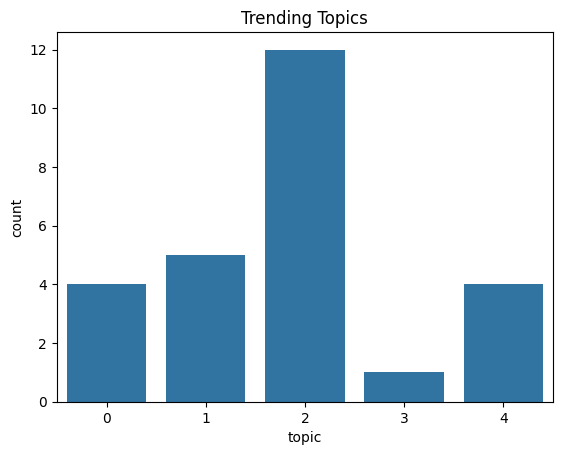

In [12]:
sns.countplot(x='topic', data=news_df)
plt.title("Trending Topics")
plt.show()

In [13]:
from textblob import TextBlob


news_df['sentiment'] = news_df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

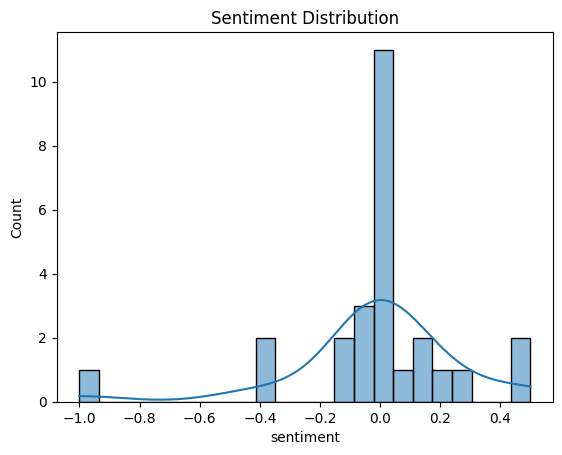

In [14]:
sns.histplot(news_df['sentiment'], kde=True)
plt.title("Sentiment Distribution")
plt.show()

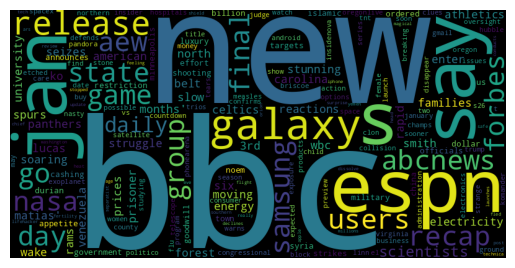

In [15]:
text = ' '.join(news_df['clean_headline'])
wordcloud = WordCloud(width=800, height=400).generate(text)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [16]:
wordcloud.to_file("news_wordcloud.png")

In [17]:
img = load_img('news_wordcloud.png', target_size=(128,128))
img_array = img_to_array(img) / 255.0
X_img = np.expand_dims(img_array, axis=0)


y_img = np.array([1])

In [18]:
model = Sequential([
Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
MaxPooling2D(2,2),
Conv2D(64, (3,3), activation='relu'),
MaxPooling2D(2,2),
Flatten(),
Dense(64, activation='relu'),
Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(X_img, y_img, epochs=5)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.6283
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 1.0000 - loss: 4.7626e-05
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 1.0000 - loss: 4.7281e-08
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.6733e-10
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 1.0000 - loss: 1.3074e-12
